In [1]:
import datetime, logging, os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# These are my custom libraries
import markets_lib as ml

%matplotlib inline
logging.basicConfig(format = '%(funcName)s %(asctime)-25s %(message)s', level = logging.INFO)

In [2]:
# Set up ticker_dfs. For each day_ticker, a DataFrame where columns are 
# times and rows contain the data for single days

tickers = ['SPY','TQQQ', 'SOXL', 'LABU', 'SQQQ', 'SOXS', 'LABD', 'CURE', 'DFEN']
tickers = ['SOXL', 'LABU', 'TQQQ', 'SOXS', 'LABD', 'SQQQ']
#tickers = ['SOXL', 'SOXS']
ticker_dfs = [ml.timeseries.transform_intraday_df(ml.timeseries.Ticker(t, av_func='TIME_SERIES_INTRADAY_EXTENDED')) for t in tickers]
print('Here\'s the parsed dataframe for {}'.format(tickers[0]))
ticker_dfs[0]

Here's the parsed dataframe for SOXL


,09:30,09:35,09:40,09:45,09:50,09:55,10:00,10:05,10:10,10:15,...,15:15,15:20,15:25,15:30,15:35,15:40,15:45,15:50,15:55,16:00
2020-09-21,14.163221,14.352117,14.010049,14.139277,14.480480,14.308332,14.319526,14.185836,14.237716,14.283609,...,14.668385,14.706630,14.796422,14.742441,14.737891,14.813716,14.844312,14.769817,14.878898,14.974011
2020-09-22,14.068773,15.037864,14.992635,14.818365,14.758770,14.696826,14.712616,14.830264,14.813716,14.851628,...,15.297928,15.339499,15.340497,15.414326,15.387056,15.445587,15.471194,15.505448,15.505448,15.499462
2020-09-23,14.068773,15.475411,15.529060,15.603860,15.713633,15.464875,15.448912,15.477513,15.337836,15.365771,...,14.596884,14.576265,14.522390,14.585803,14.552986,14.589568,14.617018,14.448561,14.269642,14.366750
2020-09-24,14.068773,14.123314,14.264986,14.330501,14.616845,14.675363,14.650760,14.821697,14.939425,14.795092,...,14.798810,14.709291,14.555646,14.580748,14.598880,14.739222,14.777599,14.699979,14.765162,14.785115
2020-09-25,14.805734,14.478492,14.407822,14.423286,14.260330,14.280284,14.513743,14.437646,14.432598,14.316533,...,15.414991,15.506778,15.481504,15.470862,15.382779,15.355129,15.426963,15.425633,15.438270,15.416321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-01,13.010000,12.945000,12.840000,12.850000,12.620000,12.599900,12.589100,12.400000,12.399900,12.270000,...,13.180000,13.060100,13.050100,12.915000,12.900100,12.900000,12.880000,12.925000,13.055000,13.210900
2022-09-02,13.850000,13.331800,13.410000,13.285000,13.400000,13.460000,13.350100,13.250000,13.460000,13.660000,...,12.940000,12.950000,12.816100,12.890000,12.750000,12.675000,12.655000,12.770000,12.905000,12.820100
2022-09-06,12.890000,12.690300,12.665000,12.820000,12.720000,12.562000,12.605000,12.320000,12.170000,12.190000,...,12.480000,12.460000,12.495000,12.470400,12.400000,12.400000,12.509000,12.510000,12.425000,12.409900
2022-09-07,12.450000,12.650000,12.710000,12.530000,12.564500,12.435000,12.388700,12.475000,12.415000,12.309900,...,13.250000,13.210000,13.240000,13.290000,13.210000,13.165000,13.129900,13.151000,13.100000,13.010000


### Does morning predict the day for leveraged stocks

In [3]:
# Create a list of DataFrames for each starting time noting the opening price
# as a percentage rice from the previous day's closing, and mean, max and min
# as a percentage diff from opening price. NOTE: Min price should ideally occur
# before the max price for the day (if max price is more than threshold percentage
# above the open price - i.e. we don't care about the min if we've sold before it.)

timestamps = ticker_dfs[0].columns
buy_earliest = '09:30'
buy_latest = '11:00'
day_close = '16:00'
buy_earliest_index = list(timestamps).index(buy_earliest)
buy_latest_index = list(timestamps).index(buy_latest)
day_close_index = list(timestamps).index(day_close)
steps = 6    # How many steps to skip

# The index of the tick to take as opening price. 0 means 9:30, 1 means 9.35 etc
buy_time_index = list(range(buy_earliest_index, buy_latest_index+1, steps))
# List of list of dataframes, each row will contain a ticker with the different buy times
ticker_timestamp_dfs = []  

for ticker_i, ticker in enumerate(tickers):
    ticker_timestamp_df_row = [] # A row, timestamps for the same ticker
    for buy_time in buy_time_index:
        df_rows = []
        for tick_i, (date, tick) in enumerate(ticker_dfs[ticker_i].iterrows()):
            tick = tick[buy_time:day_close_index]
            if tick_i == 0:    # Skip the first row
                day_close = tick[-1]
                continue
            day_open = tick[0]
            day_max = (np.max(tick[1:])-day_open)*100/day_open
            day_max_index = np.argmax(tick[1:])
            day_mean = (np.average(tick[1:])-day_open)*100/day_open
            day_min = (np.min(tick[1:day_max_index])-day_open)*100/day_open
            day_open = (day_open-day_close)*100/day_close
            day_close = tick[-1]
            df_row = [day_open, day_max, day_mean, day_min]
            df_rows.append(df_row)
        columns = ['{}_open'.format(ticker), '{}_max'.format(ticker), '{}_mean'.format(ticker), '{}_min'.format(ticker)]
        ticker_timestamp_df_row.append(pd.DataFrame(df_rows, columns=columns, index=ticker_dfs[ticker_i].index[1:]))
    ticker_timestamp_dfs.append(ticker_timestamp_df_row)   

print('Tickers: {}'.format(', '.join(tickers)))
print('Timestamps: {}'.format(', '.join([timestamps[bt] for bt in buy_time_index])))
print('Created {} rows x {} columns grid of dataframes'.format(len(ticker_timestamp_dfs), len(ticker_timestamp_dfs[0])))
for row_ in ticker_timestamp_dfs:
    for ci_, col_ in enumerate(row_):
        print(col_.columns[0].split('_')[0]+'_{}'.format(timestamps[buy_time_index[ci_]]), end=' ')
    print()
ticker_timestamp_dfs[0][0]

Tickers: SOXL, LABU, TQQQ, SOXS, LABD, SQQQ
Timestamps: 09:30, 10:00, 10:30, 11:00
Created 6 rows x 4 columns grid of dataframes
SOXL_09:30 SOXL_10:00 SOXL_10:30 SOXL_11:00 
LABU_09:30 LABU_10:00 LABU_10:30 LABU_11:00 
TQQQ_09:30 TQQQ_10:00 TQQQ_10:30 TQQQ_11:00 
SOXS_09:30 SOXS_10:00 SOXS_10:30 SOXS_11:00 
LABD_09:30 LABD_10:00 LABD_10:30 LABD_11:00 
SQQQ_09:30 SQQQ_10:00 SQQQ_10:30 SQQQ_11:00 


,SOXL_open,SOXL_max,SOXL_mean,SOXL_min
2020-09-22,-5.444792,10.211800,6.714709,3.526853
2020-09-23,-9.265614,11.691566,7.531326,9.998298
2020-09-24,-1.407663,8.807678,5.866834,0.387670
2020-09-25,0.274787,4.734951,1.349599,-3.683738
2020-09-28,3.614665,4.158004,2.018546,-1.370062
...,...,...,...,...
2022-09-01,-8.186309,1.306687,-4.152430,-7.686395
2022-09-02,6.089621,1.732852,-4.033607,-4.332130
2022-09-06,-0.116234,0.543057,-2.687062,-5.585725
2022-09-07,0.201207,6.746988,2.761967,-1.125301


In [4]:
# What happens if we only keep the dates where all stocks in the list had 
# correlated starts. i.e. long stocks went the same direction and short stocks
# went the opposite direction. 
# ticker_timestamp_dfs_subset will only contains the days where there is correlation

ticker_timestamp_dfs_intersection_=[[None]*len(ticker_timestamp_dfs[0]) for r_ in ticker_timestamp_dfs]

# First, only keep common dates to all tickers
indices_ = [df_row_[0].index for df_row_ in ticker_timestamp_dfs]
common_indices_ = indices_[0]
for index_ in indices_[1:]:
    common_indices_ = common_indices_.intersection(index_)

for icol_ in range(len(ticker_timestamp_dfs[0])):
    for irow_ in range(len(ticker_timestamp_dfs)):
        ticker_timestamp_dfs_intersection_[irow_][icol_] = ticker_timestamp_dfs[irow_][icol_].loc[common_indices_]

directions_ = np.array([1,1,1,-1,-1,-1])
#directions_ = np.array([1,-1])
filter_ = []
filters_ = []
ticker_timestamp_dfs_subset=[[None]*len(ticker_timestamp_dfs[0]) for r_ in ticker_timestamp_dfs_intersection_]

for icol_ in range(len(ticker_timestamp_dfs_intersection_[0])):
    df_ = ticker_timestamp_dfs_intersection_[0][icol_]
    filter_ = []
    for i_, (date_, tick_) in enumerate(df_.iterrows()):
        vals_ = [tick_[0]]
        for irow_ in range(1, len(ticker_timestamp_dfs_intersection_)):
            try:
                vals_.append(ticker_timestamp_dfs_intersection_[irow_][icol_].iloc[i_][0])
            except IndexError:
                vals_.append(False)
        vals_ = np.array([-1 if (v_<0 or v_==False) else 1 for v_ in vals_])
        vals_ = np.abs(np.sum(vals_*directions_))
        if vals_ == len(directions_):
            filter_.append(True)
        else:
            filter_.append(False)
    filters_.append(filter_)

for icol_ in range(len(ticker_timestamp_dfs_intersection_[0])):
    for irow_ in range(len(ticker_timestamp_dfs)):
        ticker_timestamp_dfs_subset[irow_][icol_] = ticker_timestamp_dfs_intersection_[irow_][icol_][filters_[icol_]]

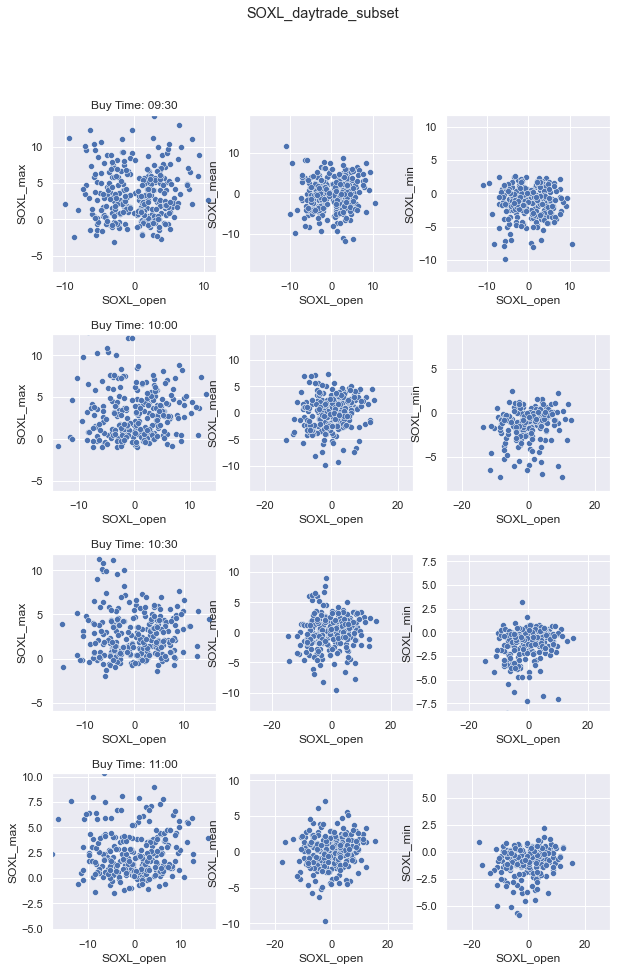

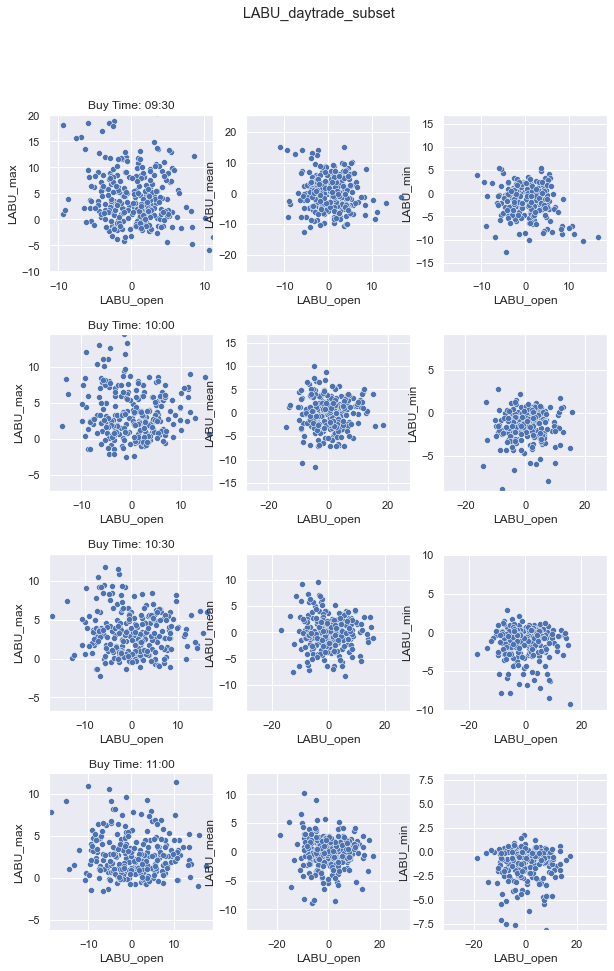

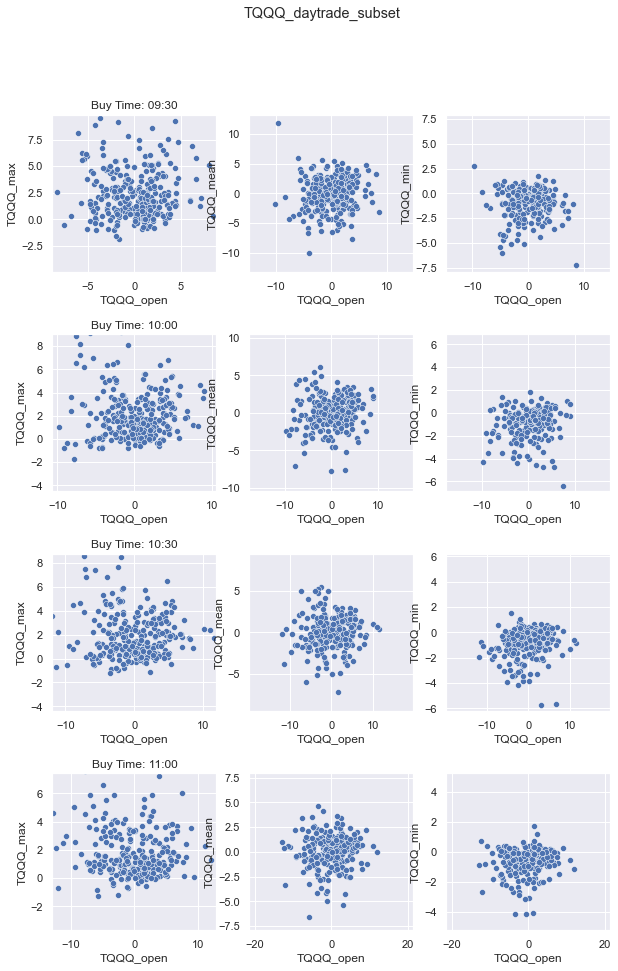

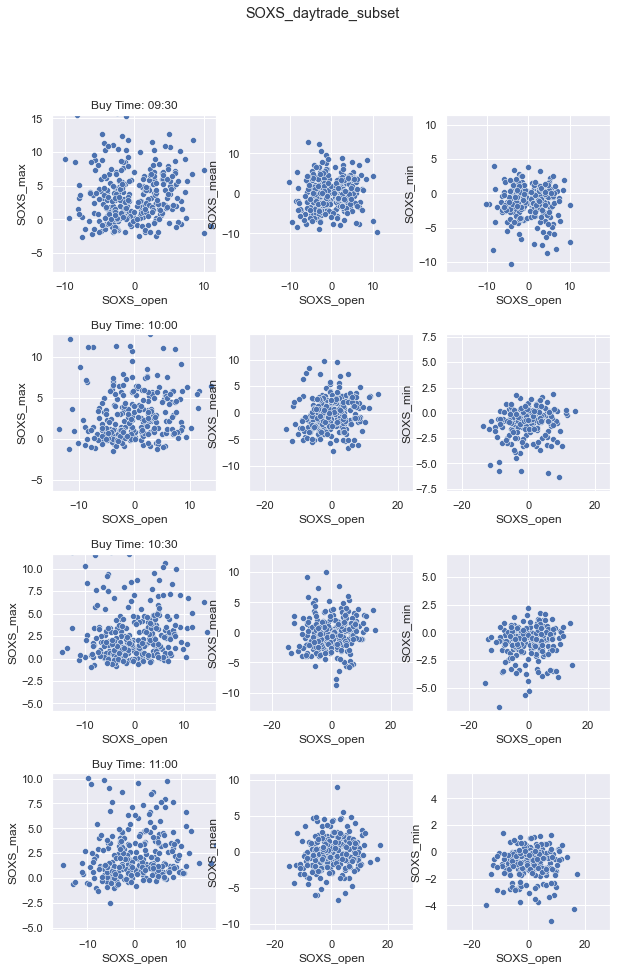

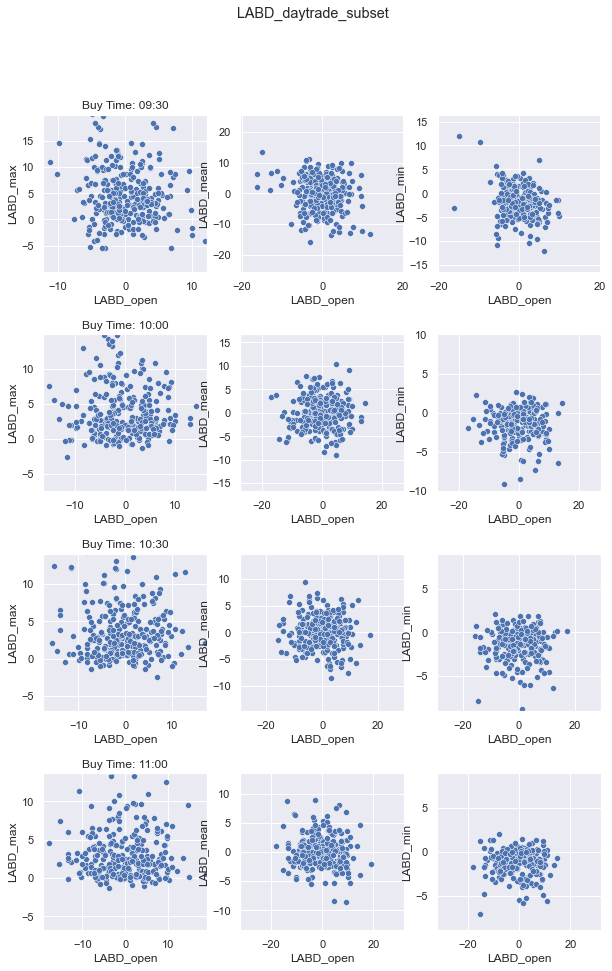

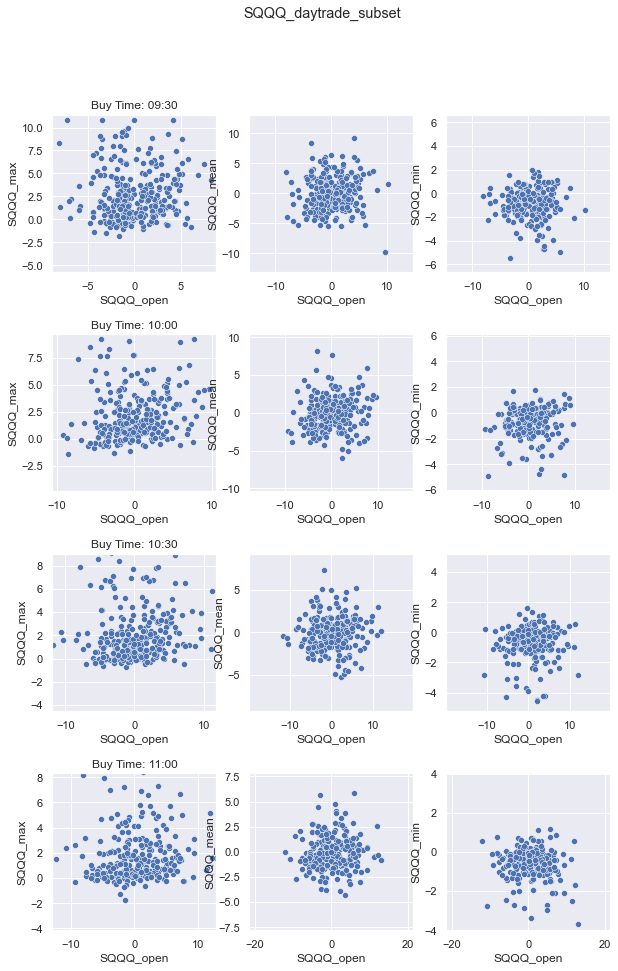

In [5]:
# Use ticker_timestamp_dfs_subset to plot only days where tickers are correlated (all up or down)
# Use ticker_timestamp_dfs to plot all
ncols = 3  # number of grid columns
subset = True

dfs_ = ticker_timestamp_dfs_subset if subset else ticker_timestamp_dfs
for i_ticker, dfs in enumerate(dfs_):
    # Set up the plot
    sns.set_theme(style="darkgrid")
    nrows = len(dfs)
    fig = plt.figure(figsize=(10,15))
    grid = plt.GridSpec(nrows, ncols, hspace=.4)
    
    for i_timestamp, df in enumerate(dfs):
        ax_1 = fig.add_subplot(grid[i_timestamp, 0])
        ax_2 = fig.add_subplot(grid[i_timestamp, 1])
        ax_3 = fig.add_subplot(grid[i_timestamp, 2])

        p = sns.scatterplot(x=df.columns[0], y=df.columns[1], data=df, ax=ax_1)
        xlim = df[df.columns[0]].std()
        ylim = df[df.columns[1]].std()
        p.set_xlim((-xlim*3, xlim*3))
        p.set_ylim((-ylim*2, ylim*4))
        ax_1.set_title('Buy Time: {}'.format(timestamps[buy_time_index[i_timestamp]]))
        p = sns.scatterplot(x=df.columns[0], y=df.columns[2], data=df, ax=ax_2)
        xlim = df[df.columns[0]].std()*5
        ylim = df[df.columns[2]].std()*5
        p.set_xlim((-xlim, xlim))
        p.set_ylim((-ylim, ylim))

        p = sns.scatterplot(x=df.columns[0], y=df.columns[3], data=df, ax=ax_3)
        xlim = df[df.columns[0]].std()*5
        ylim = df[df.columns[3]].std()*5
        p.set_xlim((-xlim, xlim))
        p.set_ylim((-ylim, ylim))
        
    filename = '{}_daytrade_{}'.format(tickers[i_ticker], 'subset' if subset else 'all')
    fig.suptitle(filename)
    plt.show()
    plt.close()
    fig.savefig('../vis/{}.png'.format(filename))

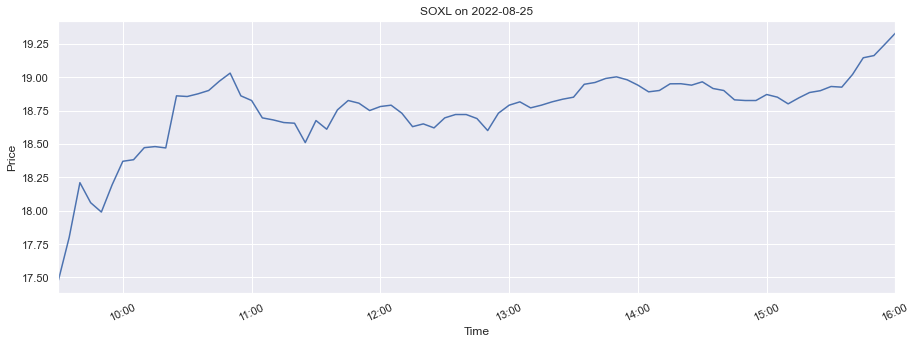

In [6]:
# Plot data for a single day
plot_tickers = ['SOXL']
date_str = '2022-08-25'

date = datetime.datetime.strptime(date_str, '%Y-%m-%d').date()
sns.set_theme(style="darkgrid")
fig = plt.figure(figsize=(15,5))

for pt in plot_tickers:
    pt_index = tickers.index(pt)
    pt_df = ticker_dfs[pt_index]
    prices = list(pt_df.loc[[date]].iloc[0])
    times = [pd.to_datetime(date_str+ ' ' + x_) for x_ in pt_df.columns]
    df = pd.DataFrame(zip(times, prices), columns=['Time', 'Price'])
    p = sns.lineplot(x='Time', y='Price', data=df)
    p.set_xlim(df['Time'].iloc[0], df['Time'].iloc[-1])
    p.set(title='{} on {}'.format(','.join(plot_tickers), date_str))

    xfmt = mdates.DateFormatter('%H:%M')
    p.xaxis.set_major_formatter(xfmt)
    plt.xticks(rotation=25)
plt.show()
plt.close()

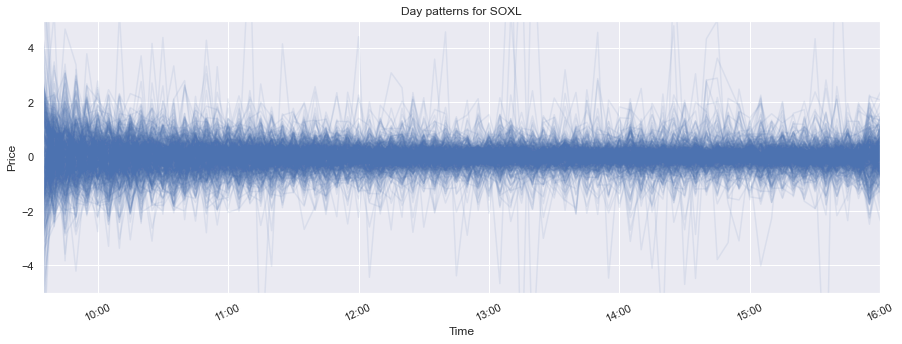

In [7]:
# Plot data for a single ticker for all days
plot_tickers = ['SOXL']
sns.set_theme(style="darkgrid")
fig = plt.figure(figsize=(15,5))

for pt in plot_tickers:
    pt_index = tickers.index(pt)
    pt_df = ticker_dfs[pt_index]
    for date in pt_df.index:
        prices = list(pt_df.loc[[date]].iloc[0])
        prices = [(p_-prices[i_])*100/prices[i_] for i_, p_ in enumerate(prices[1:])]
        times = [pd.to_datetime(date_str+ ' ' + x_) for x_ in pt_df.columns][1:]
        df = pd.DataFrame(zip(times, prices), columns=['Time', 'Price'])
        p = sns.lineplot(x='Time', y='Price', data=df, alpha=.1, color='b')   
    xfmt = mdates.DateFormatter('%H:%M')
    p.xaxis.set_major_formatter(xfmt)
    plt.xticks(rotation=25)
    p.set_xlim(times[0], times[-1])
    p.set_ylim(-5, 5)
    p.set(title='Day patterns for {}'.format(','.join(plot_tickers)))

FileNotFoundError: [Errno 2] No such file or directory: '../vis/SOXL_daily_charts/SOXL_2020-09-21.png'

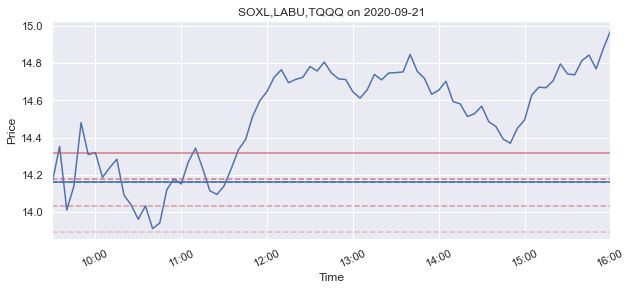

In [10]:
# Plot data for single days for single ticker. All the plots are saved
plot_ticker = 'SOXL'
trade_time_ = '10:00'

sns.set_theme(style="darkgrid")

pt_index = tickers.index(plot_ticker)
pt_df = ticker_dfs[pt_index]
for i_, (date_, ticker_) in enumerate(pt_df.iterrows()):
    fig = plt.figure(figsize=(10,4))
    date_ = date_.strftime('%Y-%m-%d')
    last_close_ = prices[-1] if i_>0 else ticker_[0]
    prices = ticker_
    times = [pd.to_datetime(date_+ ' ' + x_) for x_ in pt_df.columns]
    df = pd.DataFrame(zip(times, prices), columns=['Time', 'Price'])
    p = sns.lineplot(x='Time', y='Price', data=df)
    p.axhline(last_close_, alpha=1, ls='--')
    p.axhline(prices[0], alpha=1, ls='-')

    trade_time_index_ = list(pt_df.columns).index(trade_time_)
    p.axhline(prices[trade_time_index_], color='r', ls='-', alpha=.7)
    p.axhline(prices[trade_time_index_]*.99, color='r', ls='--', alpha=.7)
    p.axhline(prices[trade_time_index_]*.98, color='r', ls='--', alpha=.5)
    p.axhline(prices[trade_time_index_]*.97, color='r', ls='--', alpha=.3)
    p.set_xlim(df['Time'].iloc[0], df['Time'].iloc[-1])
    p.set(title='{} on {}'.format(','.join(plot_tickers), date_))

    xfmt = mdates.DateFormatter('%H:%M')
    p.xaxis.set_major_formatter(xfmt)
    plt.xticks(rotation=25)
    file_name_ = '../vis/{}_daily_charts/{}_{}.png'.format(plot_ticker, plot_ticker, date_)
    plt.savefig(file_name_)
    print(date_, file_name_)
    #plt.show()
    plt.close()

../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2020-09-21.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2020-09-22.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2020-09-23.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2020-09-24.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2020-09-25.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2020-09-28.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2020-09-29.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2020-09-30.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2020-10-01.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2020-10-02.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2020-10-05.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_

../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2021-02-04.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2021-02-05.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2021-02-08.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2021-02-09.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2021-02-10.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2021-02-11.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2021-02-12.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2021-02-16.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2021-02-17.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2021-02-18.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2021-02-19.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_

../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2021-06-21.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2021-06-22.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2021-06-23.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2021-06-24.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2021-06-25.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2021-06-28.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2021-06-29.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2021-06-30.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2021-07-01.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2021-07-02.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2021-07-06.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_

../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2021-11-02.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2021-11-03.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2021-11-04.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2021-11-05.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2021-11-08.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2021-11-09.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2021-11-10.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2021-11-11.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2021-11-12.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2021-11-15.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2021-11-16.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_

../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2022-03-18.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2022-03-21.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2022-03-22.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2022-03-23.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2022-03-24.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2022-03-25.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2022-03-28.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2022-03-29.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2022-03-30.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2022-03-31.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2022-04-01.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_

../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2022-08-03.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2022-08-04.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2022-08-05.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2022-08-08.png
../vis/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_daily/SOXL_SOXS_LABU_LABD_TQQQ_SQQQ_2022-08-09.png


IndexError: single positional indexer is out-of-bounds

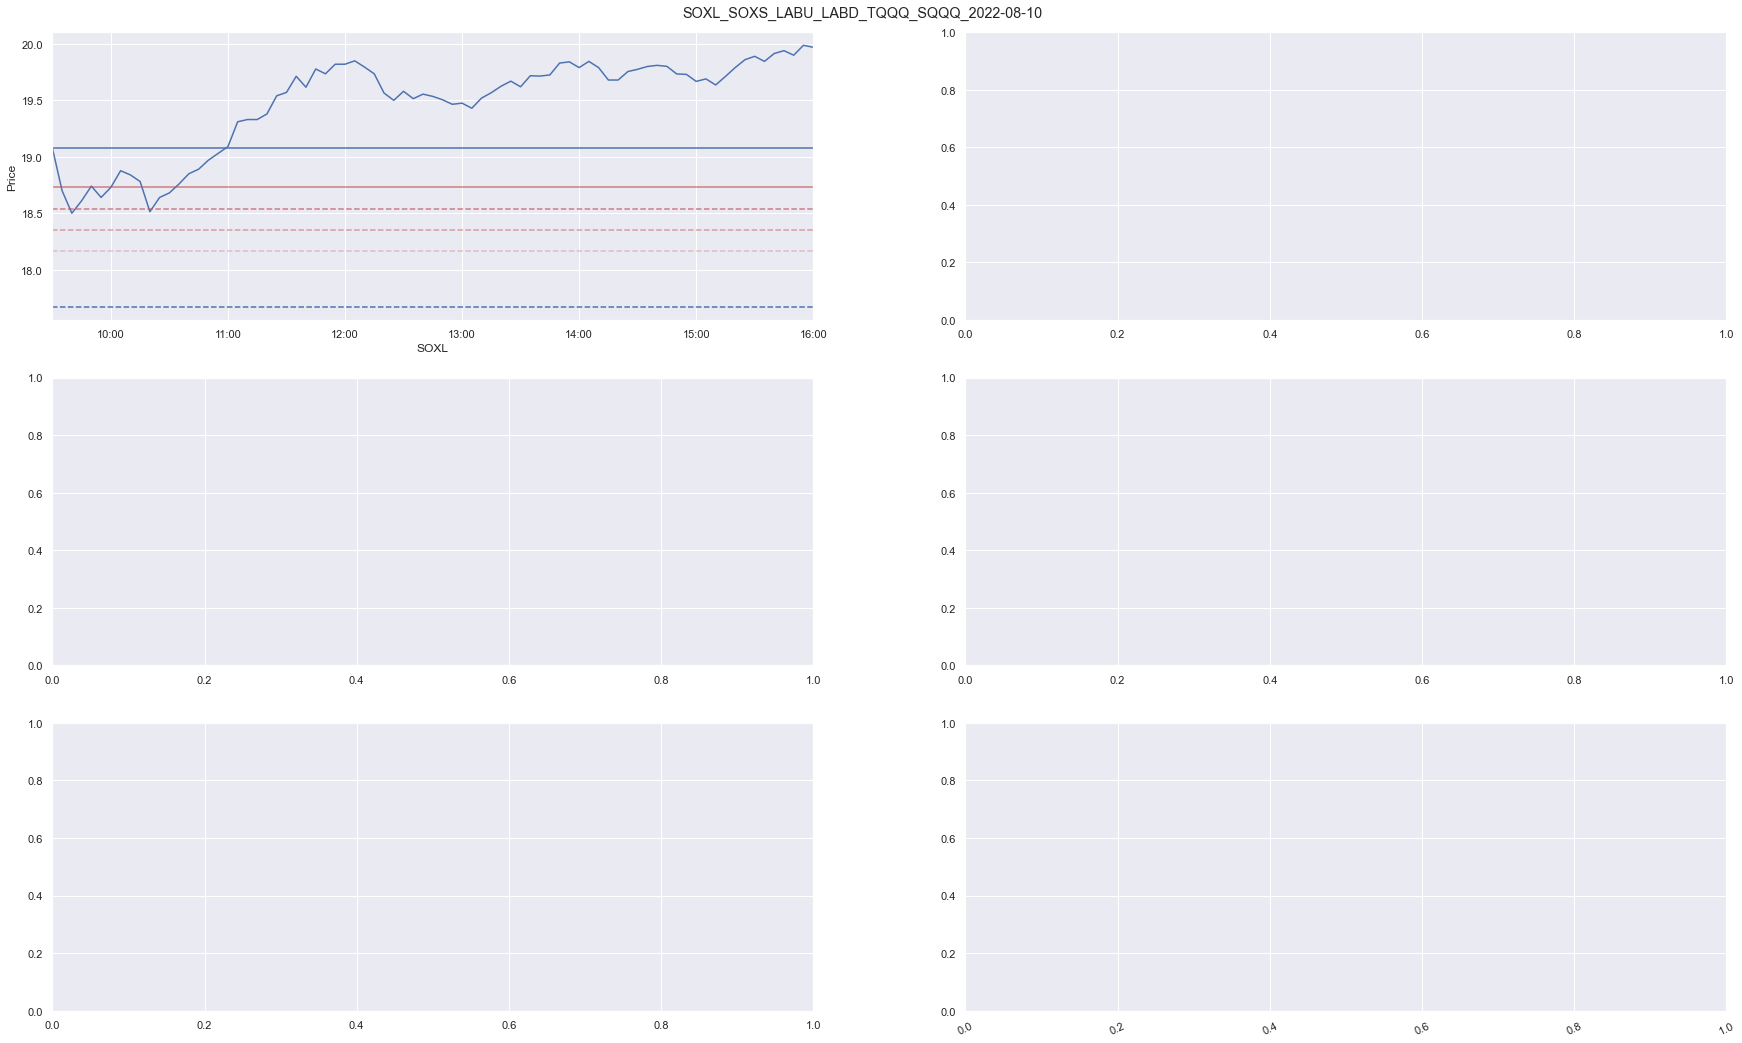

In [23]:
# Plot data for single days for single ticker. All the plots are saved
plot_tickers_ = ['SOXL', 'SOXS', 'LABU', 'LABD', 'TQQQ', 'SQQQ']
trade_time_ = '10:00'

#last_close_ = [0] * len(plot_tickers_)
pt_index_ = tickers.index(plot_tickers_[0]) 
pt_df_ = ticker_dfs[pt_index_]
sns.set_theme(style="darkgrid")

for i_, (date_, ticker_) in enumerate(pt_df_.iterrows()):
    fig = plt.figure(figsize=(30,3*len(plot_tickers_)))
    grid_ = plt.GridSpec(int(len(plot_tickers_)/2), 2)
    ax_ = [fig.add_subplot(grid_[int(pti_/2), pti_%2]) for pti_, pt_ in enumerate(plot_tickers_)]
    date_ = date_.strftime('%Y-%m-%d')

    for pti_, pt_ in enumerate(plot_tickers_):
        pt_index_ = tickers.index(pt_)
        pt_df_ = ticker_dfs[pt_index_]
        prices_ = pt_df_.iloc[i_]
        times_ = [pd.to_datetime(date_+ ' ' + x_) for x_ in pt_df_.columns]
        df_ = pd.DataFrame(zip(times_, prices_), columns=[pt_, 'Price'])
        p = sns.lineplot(x=pt_, y='Price', data=df_, ax=ax_[pti_])

        last_close_ = pt_df_.iloc[i_-1][-1] if i_>0 else pt_df_.iloc[i_][0]

        p.axhline(last_close_, alpha=1, ls='--')
        p.axhline(prices_[0], alpha=1, ls='-')

        trade_time_index_ = list(pt_df_.columns).index(trade_time_)
        p.axhline(prices_[trade_time_index_], color='r', ls='-', alpha=.7)
        p.axhline(prices_[trade_time_index_]*.99, color='r', ls='--', alpha=.7)
        p.axhline(prices_[trade_time_index_]*.98, color='r', ls='--', alpha=.5)
        p.axhline(prices_[trade_time_index_]*.97, color='r', ls='--', alpha=.3)
        p.set_xlim(df_[pt_].iloc[0], df_[pt_].iloc[-1])
        filename_ = '{}_{}'.format('_'.join(plot_tickers_), date_)
        fig.suptitle(filename_, y=.90)

        xfmt = mdates.DateFormatter('%H:%M')
        p.xaxis.set_major_formatter(xfmt)
        plt.xticks(rotation=25)

    #plt.show()
    filename_ = os.path.join('../vis/{}_daily'.format('_'.join(plot_tickers_)), filename_+'.png')
    print(filename_)
    plt.savefig(filename_)
    plt.close()
    